In [2]:
#importing libs
import numpy as np
import matplotlib.pyplot as plt
import glob
from data_gen import *
from predict_info import *

import seaborn as sns

import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Reshape, Dense, Flatten, Input, Conv1D, Conv1DTranspose, MaxPooling1D, UpSampling1D, BatchNormalization, ZeroPadding1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, confusion_matrix


from tensorflow.config.experimental import list_physical_devices, set_virtual_device_configuration, VirtualDeviceConfiguration

gpus = list_physical_devices('GPU')
set_virtual_device_configuration(gpus[0], [VirtualDeviceConfiguration(memory_limit=6500)])#
print(len(gpus), "Physical GPUs")   

2023-05-13 15:38:24.709066: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


1 Physical GPUs


2023-05-13 15:38:35.130545: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-13 15:38:35.144571: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-13 15:38:35.251879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-13 15:38:35.252310: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.83GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2023-05-13 15:38:35.252347: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-13 15:38:35.336881: I tensorflow/stream_executor/platfo

In [8]:
df = pd.read_csv("Data/scaled_xyz_allbin4_without_GRBs.csv") # data (hopefuly without grbs)
df = df[df['cps'] != 0]
#df['cps'] = np.log(df['cps'])
df

time         x         y         z     cps
0         1.429132 -0.692468 -0.598658  0.390487  134.25
1         1.429178 -0.645463 -0.459292  0.602585  135.25
2         1.429225 -0.537948 -0.311634  0.777485  131.75
3         1.429277 -0.348371 -0.159507  0.915272  128.00
4         1.429329 -0.111337 -0.039089  0.988705  128.75
...            ...       ...       ...       ...     ...
858615  748.154234 -0.717861 -0.163021 -0.387934  302.50
858616  748.154280 -0.040494  0.701094 -0.459898  309.00
858617  748.154326  0.660941 -0.094158 -0.523447  308.50
858618  748.154373 -0.230505 -0.590080 -0.578104  334.25
858619  748.154419 -0.485413  0.355615 -0.624056  366.75

[852512 rows x 5 columns]

In [9]:
def df_to_X(df, windowSize=64):
    dfNumpy = df.to_numpy()
    X = []
    for i in range(len(dfNumpy)-windowSize):
        if abs(dfNumpy[i+windowSize][0] - (windowSize*(dfNumpy[i+1][0]-dfNumpy[i][0])+dfNumpy[i][0])) < 0.00001:
            X.append(dfNumpy[i:i+windowSize,-1])
    return np.array(X, dtype=np.float32)

In [10]:
windowSize = 64
X = df_to_X(df,windowSize=windowSize)

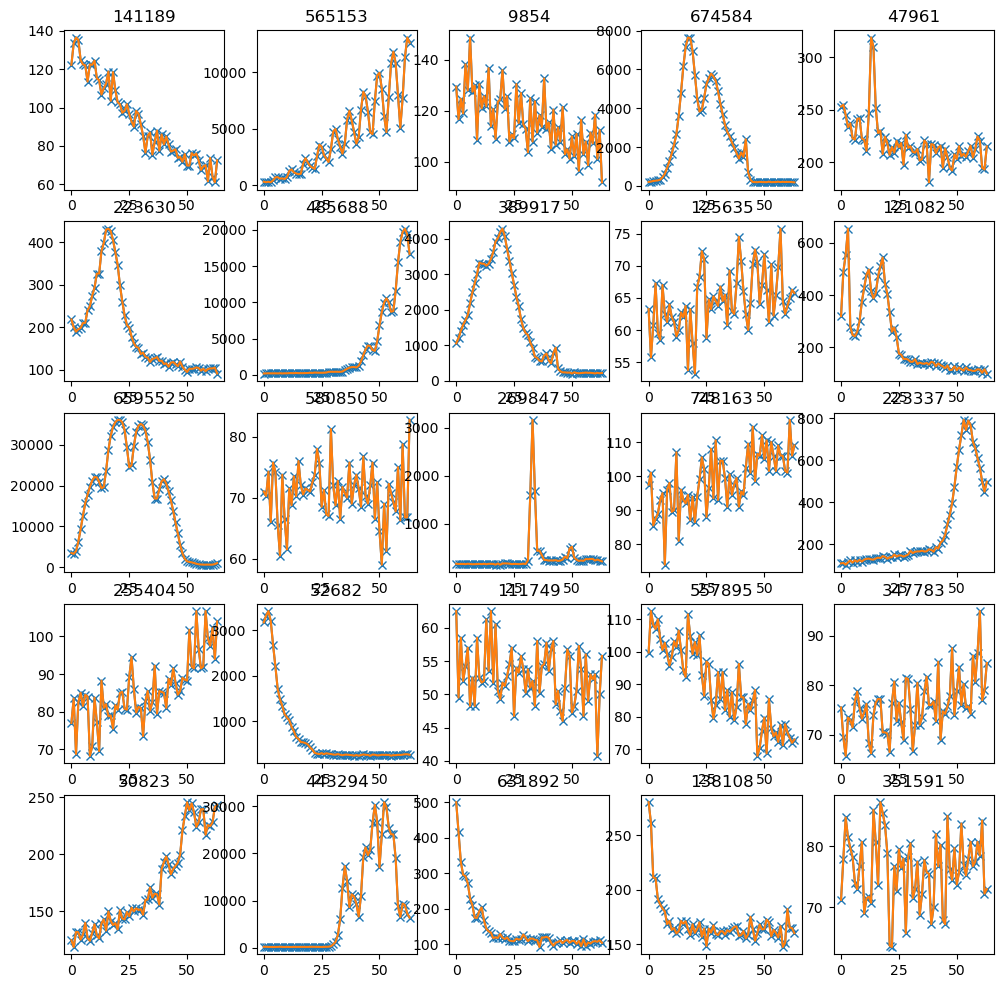

In [11]:
x = np.arange(windowSize)
fig, axs = plt.subplots(5,5,figsize=(12,12))

for i in range(5):
    for j in range(5):
        ind = np.random.randint(len(X))
        cps = [entry for entry in X[ind]]
        axs[i,j].plot(x,cps, marker='x')
        axs[i,j].plot(cps)
        axs[i,j].set_title('{}'.format(ind))

In [12]:
len(X)

760402

In [13]:
X = np.array(tf.random.shuffle(X, seed=420))

In [14]:
splitIndex = int(len(X) * 0.95)
X_train, y_train, X_test, y_test = X[0:splitIndex],X[0:splitIndex],X[splitIndex:],X[splitIndex:]

# Autoencoder

In [9]:
# Define model

def create_autoencoder():
    # Encoder
    inputs = Input(shape=(64,))
    x = Dense(64, activation="relu")(inputs)
    x = Dense(64, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    decoded = Dense(64, activation="relu")(x)
  
    # Define autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')
    return autoencoder


autoencoder = create_autoencoder()
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112  

In [10]:
fileName = '{}-{}-{}-{}'.format(datetime.datetime.today().month,
          datetime.datetime.today().day,
          datetime.datetime.today().hour,
          datetime.datetime.today().minute)
callback_conv = [EarlyStopping(monitor='val_loss', patience=11),
                 ModelCheckpoint("models/autoDense/{}.h5".format(fileName), 
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True, 
                                 mode='min'),
                ReduceLROnPlateau(monitor='val_loss',factor=0.9,patience=3,verbose=True,min_lr=0.00001),
                TensorBoard(log_dir = "./Tensor_logs/autoDense/{}".format(fileName), update_freq="epoch")]


history = autoencoder.fit(X_train, y_train,
          validation_data = (X_test, y_test),
          epochs=150, callbacks=[callback_conv],
                         shuffle=True)

2023-05-13 13:43:37.050745: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-13 13:43:37.050766: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-13 13:43:37.050793: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2023-05-13 13:43:37.051420: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2023-05-13 13:43:37.151772: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-05-13 13:43:37.152070: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-05-13 13:43:37.349760: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-13 13:43

Epoch 1/150
    1/22575 [..............................] - ETA: 2:36:35 - loss: 2147.0679

2023-05-13 13:43:37.642119: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-13 13:43:37.815898: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-13 13:43:37.815917: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-13 13:43:37.816423: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-05-13 13:43:37.818831: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-05-13 13:43:37.819428: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-05-13 13:43:37.819875: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-

22575/22575 [==============================] - 30s 1ms/step - loss: 375.9634 - val_loss: 234.7828

Epoch 00001: val_loss improved from inf to 234.78278, saving model to models/autoDense/5-13-13-43.h5
Epoch 2/150
22575/22575 [==============================] - 29s 1ms/step - loss: 222.5617 - val_loss: 193.0358

Epoch 00002: val_loss improved from 234.78278 to 193.03575, saving model to models/autoDense/5-13-13-43.h5
Epoch 3/150
22575/22575 [==============================] - 30s 1ms/step - loss: 199.7636 - val_loss: 187.9367

Epoch 00003: val_loss improved from 193.03575 to 187.93674, saving model to models/autoDense/5-13-13-43.h5
Epoch 4/150
22575/22575 [==============================] - 29s 1ms/step - loss: 192.4474 - val_loss: 182.4746

Epoch 00004: val_loss improved from 187.93674 to 182.47464, saving model to models/autoDense/5-13-13-43.h5
Epoch 5/150
22575/22575 [==============================] - 30s 1ms/step - loss: 186.2549 - val_loss: 179.4992

Epoch 00005: val_loss improved from

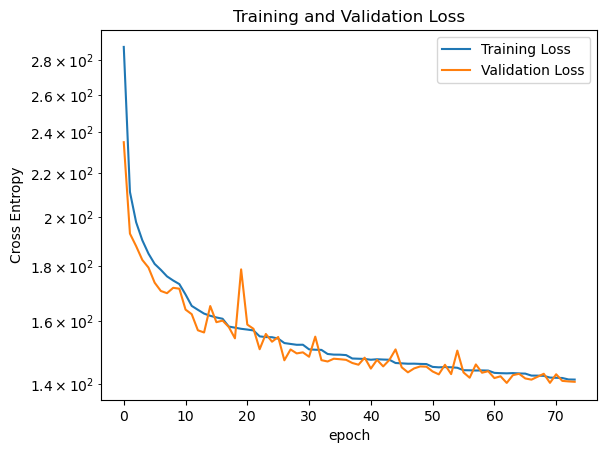

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.yscale("log")
plt.show()

In [6]:
autoencoder = load_model('models/autoDense/5-13-13-43.h5',compile=False)

2023-05-13 15:39:46.368895: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 15:39:46.369384: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-13 15:39:46.369570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-13 15:39:46.369893: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.83GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 46

In [15]:
X_pred = autoencoder.predict(X_test)
x = np.arange(len(X_test[0]))

2023-05-13 15:40:12.367992: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-13 15:40:12.394180: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2023-05-13 15:40:12.518954: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


## TEST ON TEST

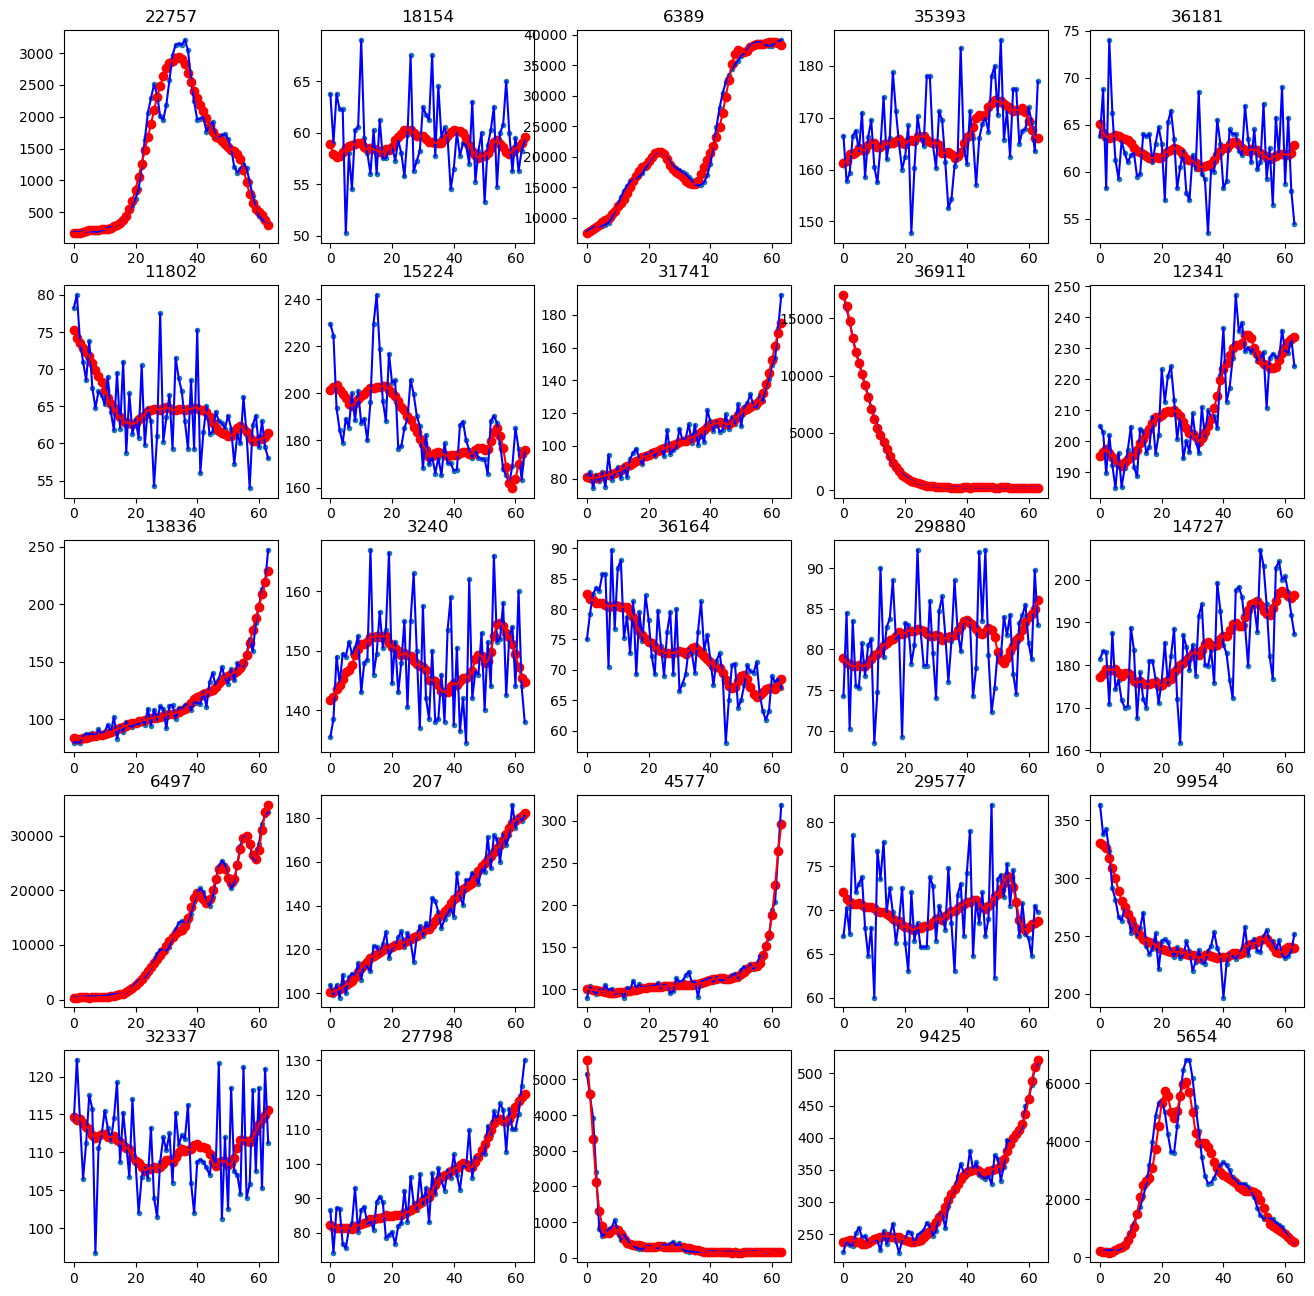

In [16]:
fig, axs = plt.subplots(5,5,figsize=(16,16))

for i in range(5):
    for j in range(5):
        ind = np.random.randint(len(y_test))
        axs[i,j].scatter(x,X_test[ind],marker='.')
        axs[i,j].scatter(x,X_pred[ind],color="red")
        axs[i,j].plot(X_test[ind],color='blue')
        axs[i,j].plot(X_pred[ind],color="red")
        axs[i,j].title.set_text('{}'.format(ind))

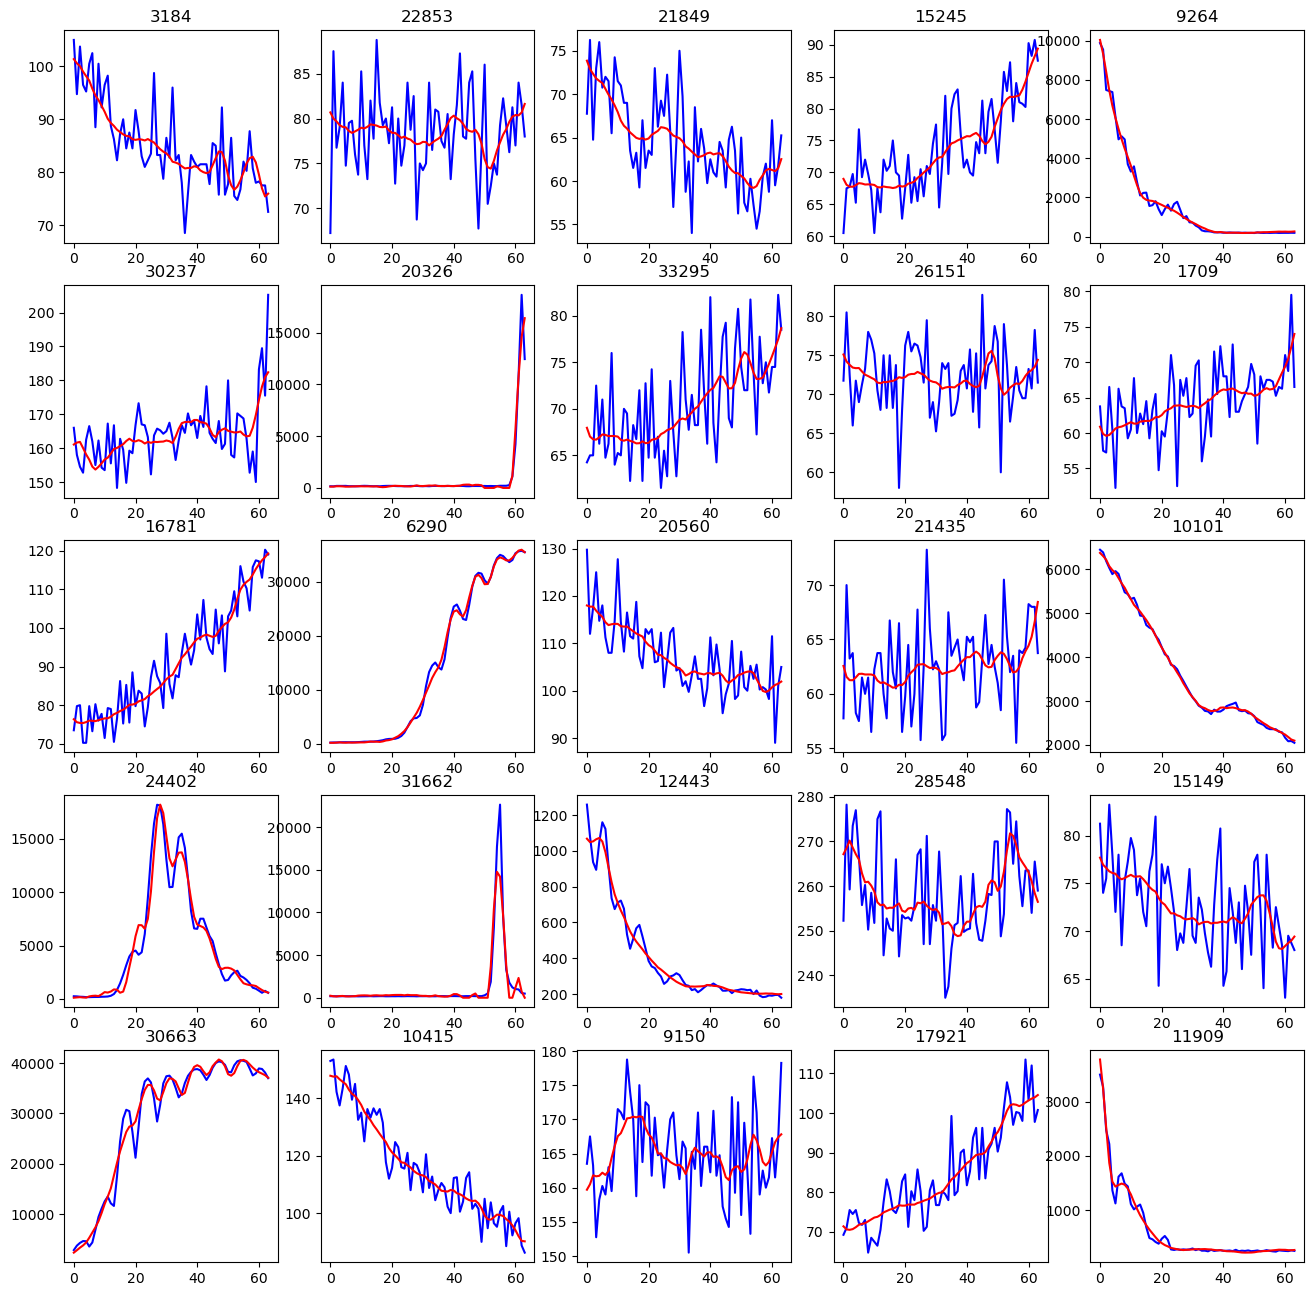

In [17]:
fig, axs = plt.subplots(5,5,figsize=(16,16))

for i in range(5):
    for j in range(5):
        ind = np.random.randint(len(y_test))
        axs[i,j].plot(X_test[ind],color='blue')
        axs[i,j].plot(X_pred[ind],color="red")
        axs[i,j].title.set_text('{}'.format(ind))

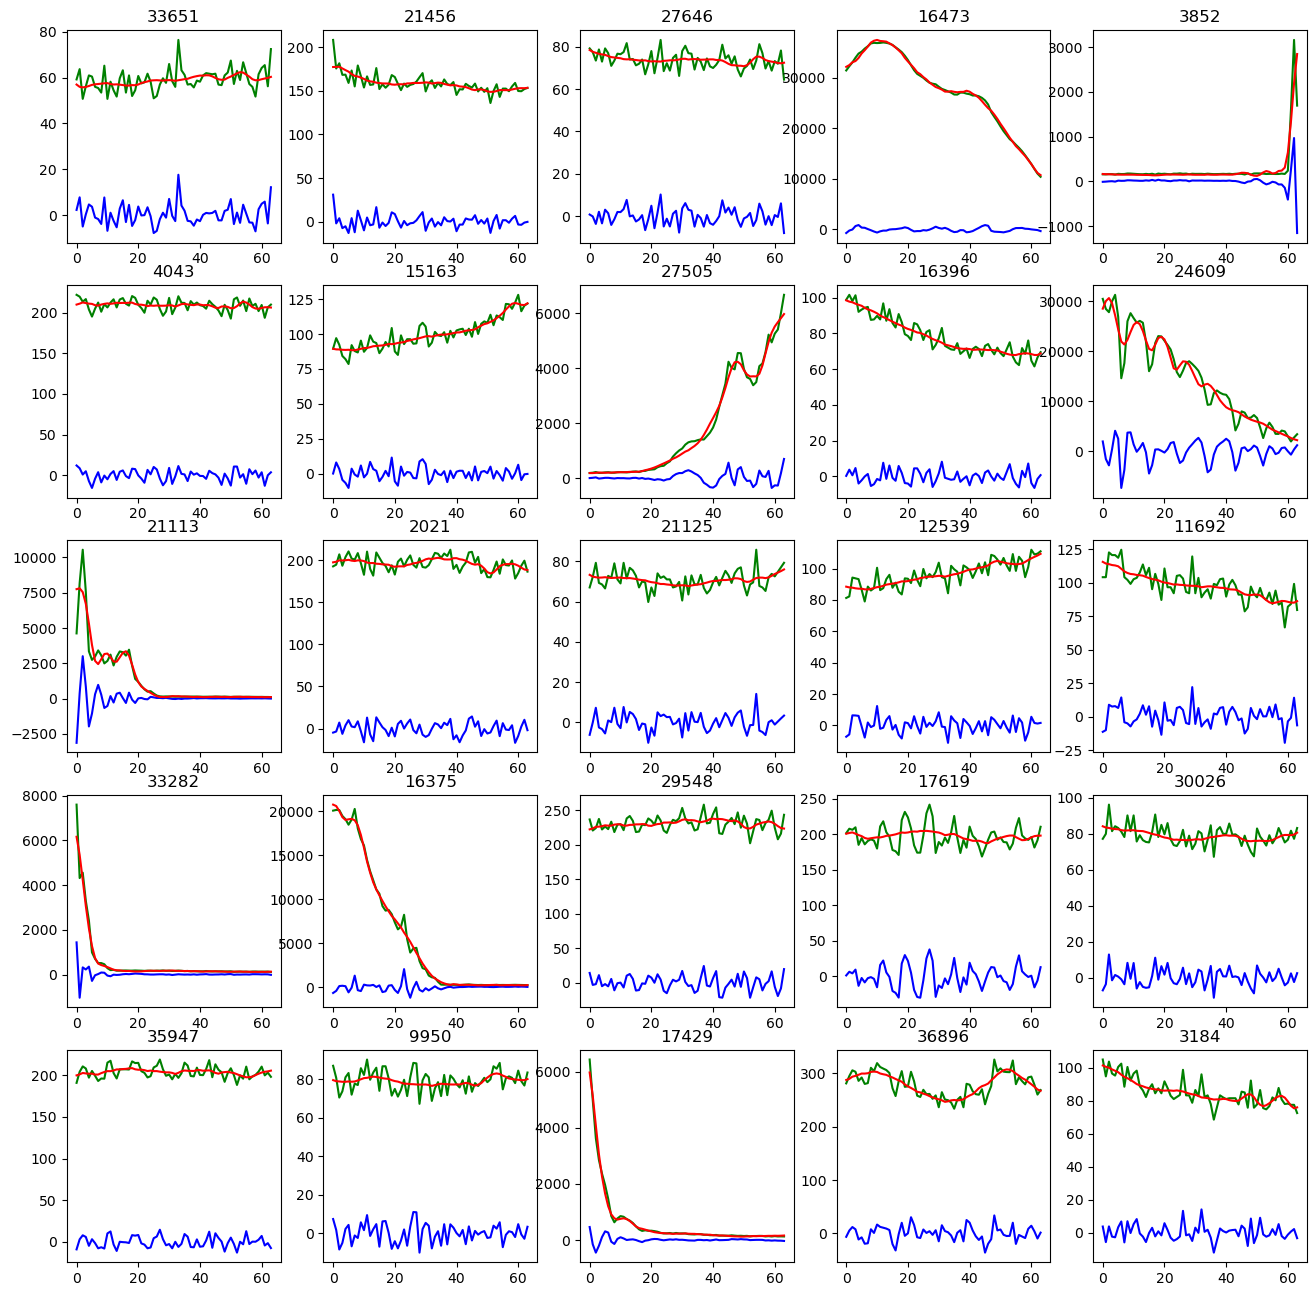

In [18]:
fig, axs = plt.subplots(5,5,figsize=(16,16))

for i in range(5):
    for j in range(5):
        ind = np.random.randint(len(y_test))
        axs[i,j].plot(X_test[ind]-X_pred[ind],color='blue')
        axs[i,j].plot(X_test[ind],color='green')
        axs[i,j].plot(X_pred[ind],color="red")
        axs[i,j].title.set_text('{}'.format(ind))

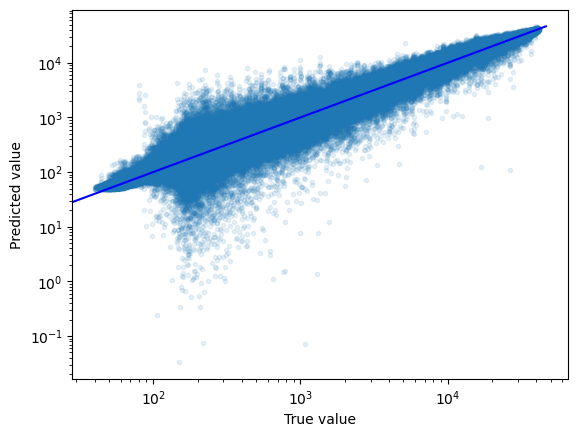

In [44]:
plt.scatter(X_test,X_pred,marker='.', alpha=0.1)
p1 = max(np.ndarray.max(X_pred), np.ndarray.max(X_test))
p2 = min(np.ndarray.min(X_pred), np.ndarray.min(X_test))
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.xscale('log')
plt.yscale('log')
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')
plt.plot([p1, p2], [p1, p2], 'b-')

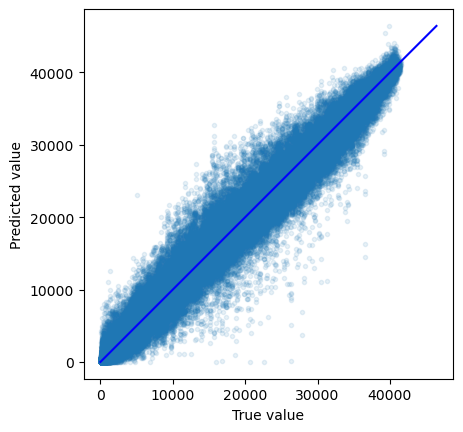

In [80]:
plt.scatter(X_test,X_pred,marker='.', alpha=0.1)
p1 = max(np.ndarray.max(X_pred), np.ndarray.max(X_test))
p2 = min(np.ndarray.min(X_pred), np.ndarray.min(X_test))
plt.xlabel('True value')
plt.ylabel('Predicted value')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.plot([p1, p2], [p1, p2], 'b-')

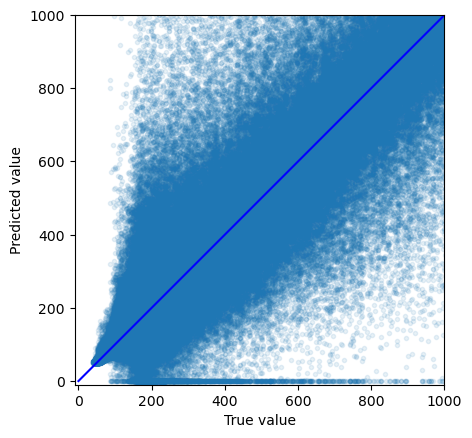

In [86]:
plt.scatter(X_test,X_pred,marker='.', alpha=0.1)
p1 = max(np.ndarray.max(X_pred), np.ndarray.max(X_test))
p2 = min(np.ndarray.min(X_pred), np.ndarray.min(X_test))
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.xlim(-10,1000)
plt.ylim(-10,1000)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.plot([p1, p2], [p1, p2], 'b-')

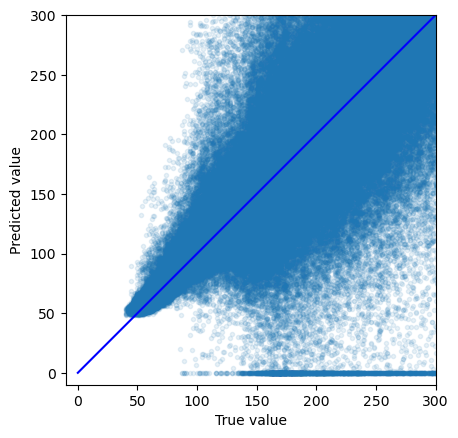

In [87]:
plt.scatter(X_test,X_pred,marker='.', alpha=0.1)
p1 = max(np.ndarray.max(X_pred), np.ndarray.max(X_test))
p2 = min(np.ndarray.min(X_pred), np.ndarray.min(X_test))
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.xlim(-10,300)
plt.ylim(-10,300)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.plot([p1, p2], [p1, p2], 'b-')

## REAL GRB

In [55]:
def isModelGood(model,windowSize):
    grbs = glob.glob("Data/scaled_xyz_128_64/*.csv")
    n_grbs = len(grbs)
    #fig, axs = plt.subplots(n_grbs,5,figsize=(30,3*n_grbs))
    pred, true = [[] for i in range(n_grbs)],[[] for i in range(n_grbs)]
    for n , grb in enumerate(grbs):
        df = pd.read_csv(grb, index_col=0)
        df = df.drop(['0'],axis=1)
        num_df = df.to_numpy()
        for i in range(int(len(num_df)/windowSize)):
            X0 = df.to_numpy()[i*windowSize:i*windowSize+windowSize,-1]
            pred[n].append(model.predict(X0.reshape(1,64)))
            true[n].append(X0)      
        
    return true, pred
#autoencoder1 = load_model('autoencoder_conv1d_workingFor512.h5')
true, pred = isModelGood(autoencoder,64)

In [64]:
true_grb, pred_grb = [],[]
for i in range(len(true)):
    true_grb.append(np.array(true[i]).flatten())
    pred_grb.append(np.array(pred[i]).flatten())

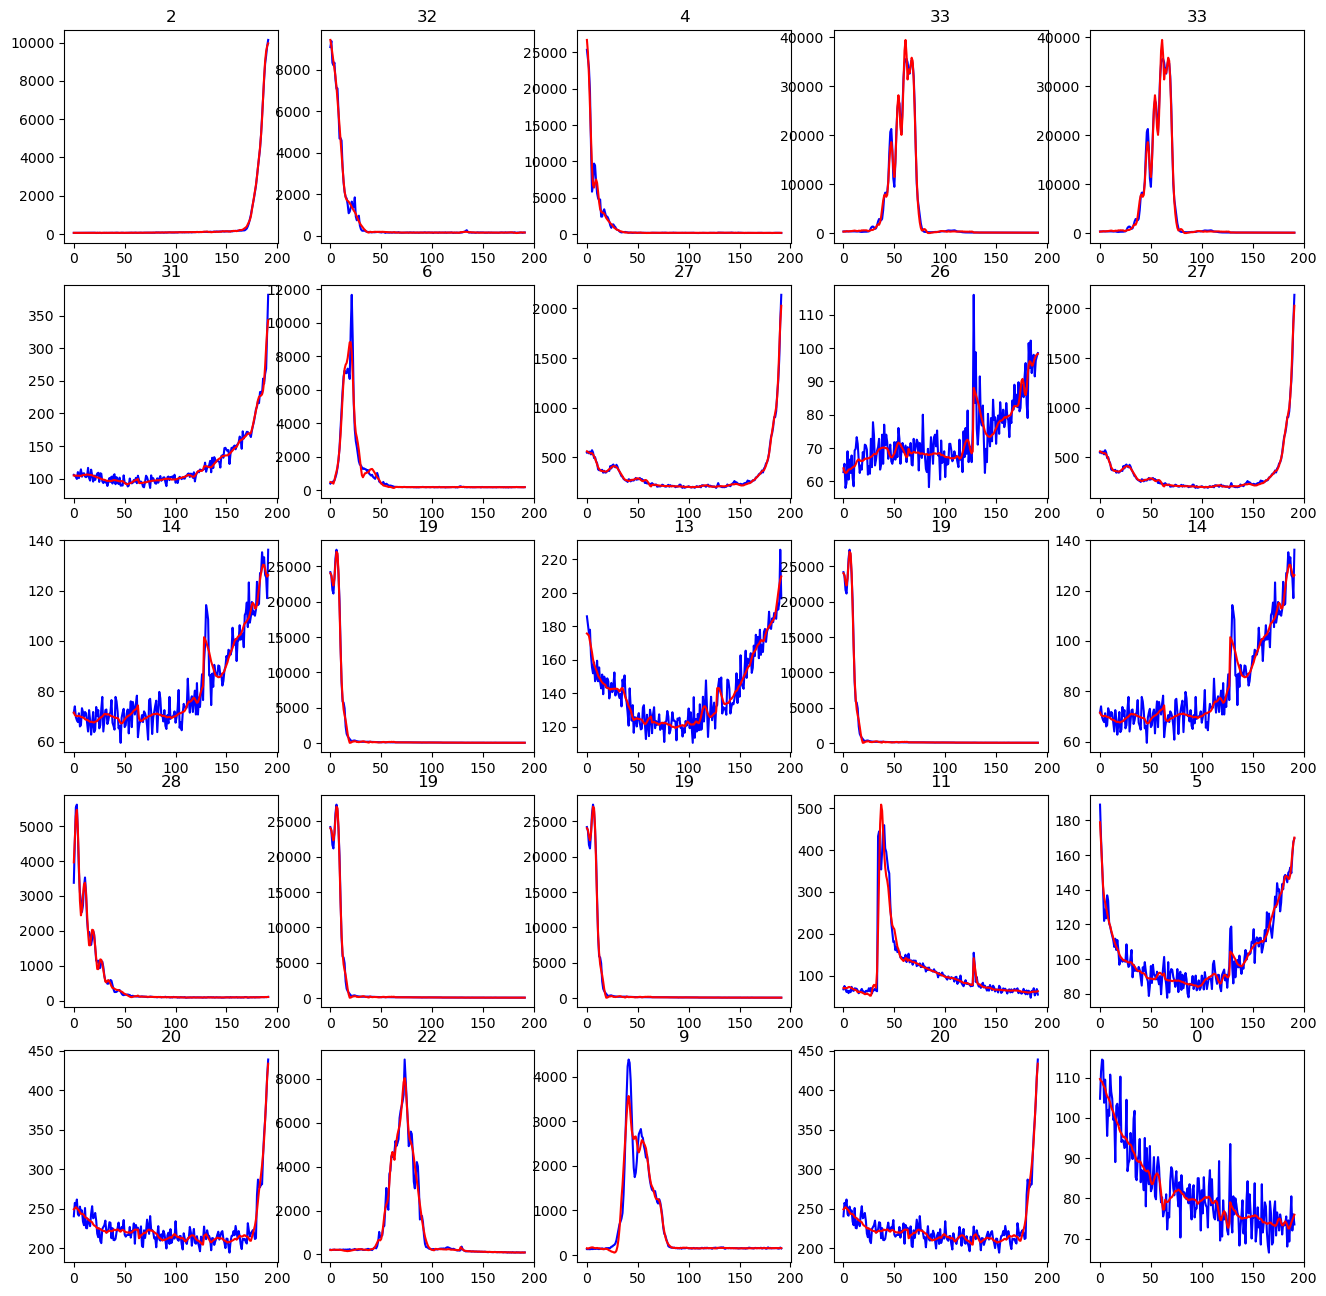

In [69]:
fig, axs = plt.subplots(5,5,figsize=(16,16))

for i in range(5):
    for j in range(5):
        ind = np.random.randint(len(true))
        axs[i,j].plot(true_grb[ind],color='blue')
        axs[i,j].plot(pred_grb[ind],color="red")
        axs[i,j].title.set_text('{}'.format(ind))

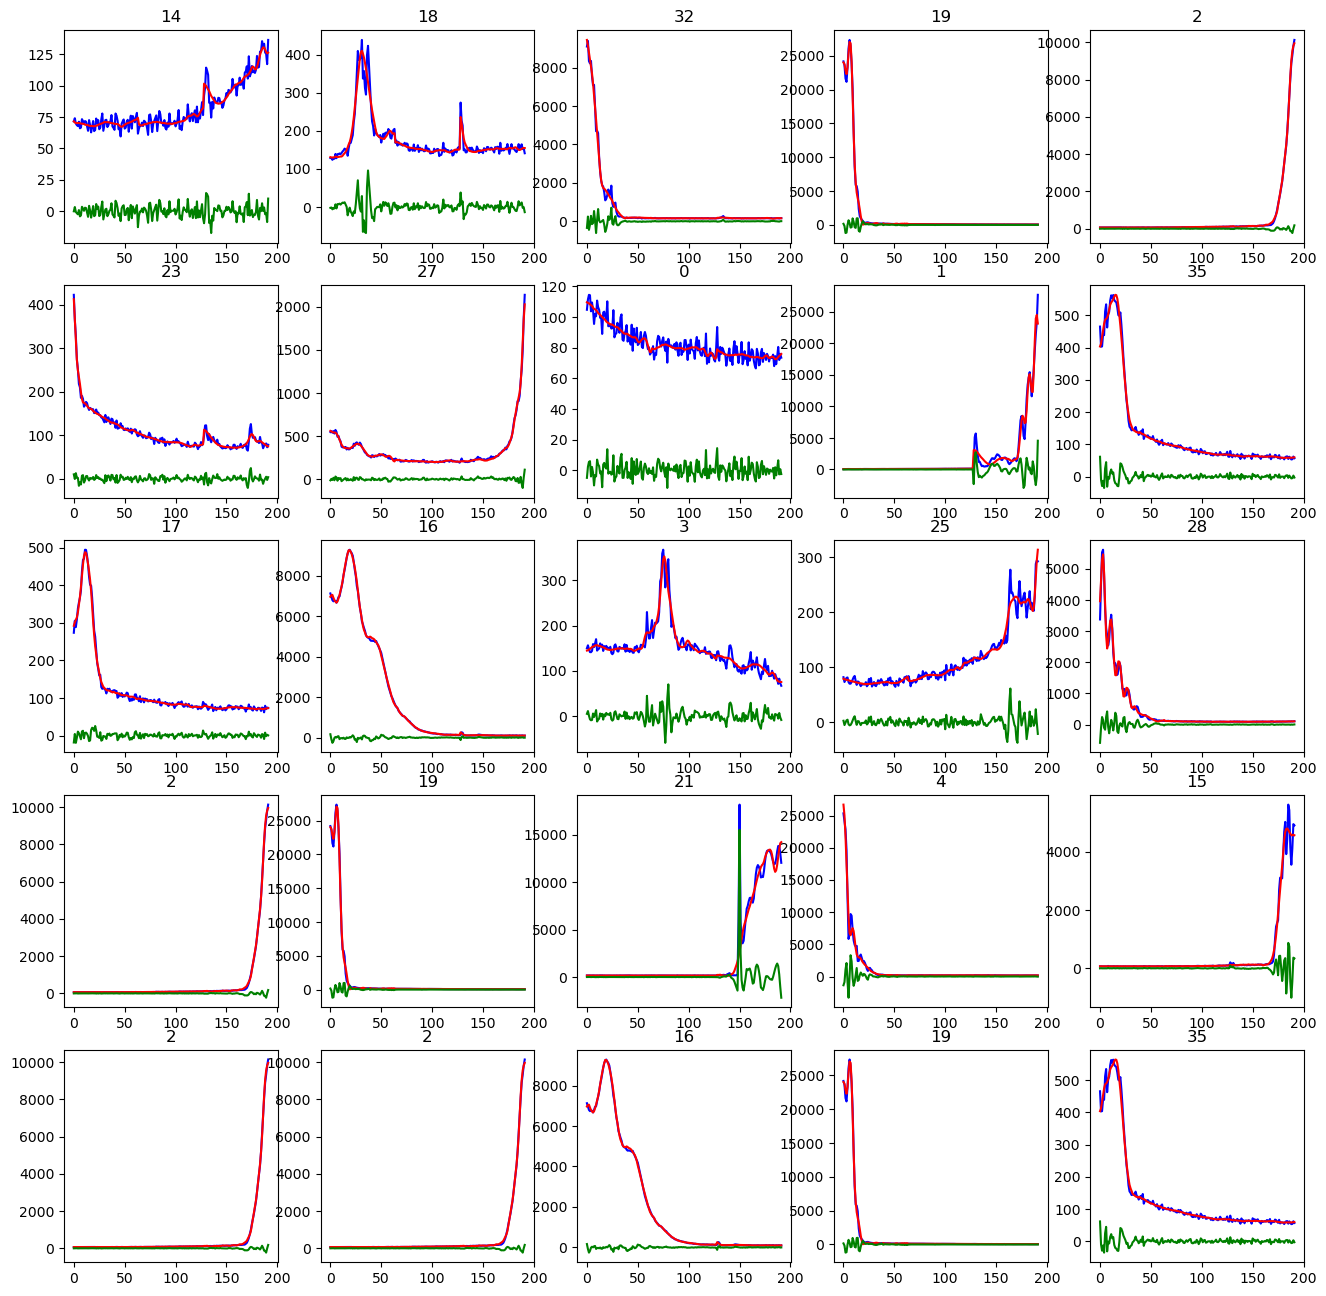

In [71]:
fig, axs = plt.subplots(5,5,figsize=(16,16))

for i in range(5):
    for j in range(5):
        ind = np.random.randint(len(true))
        axs[i,j].plot(true_grb[ind],color='blue')
        axs[i,j].plot(pred_grb[ind],color="red")
        axs[i,j].plot(true_grb[ind] - pred_grb[ind],color="green")
        axs[i,j].title.set_text('{}'.format(ind))

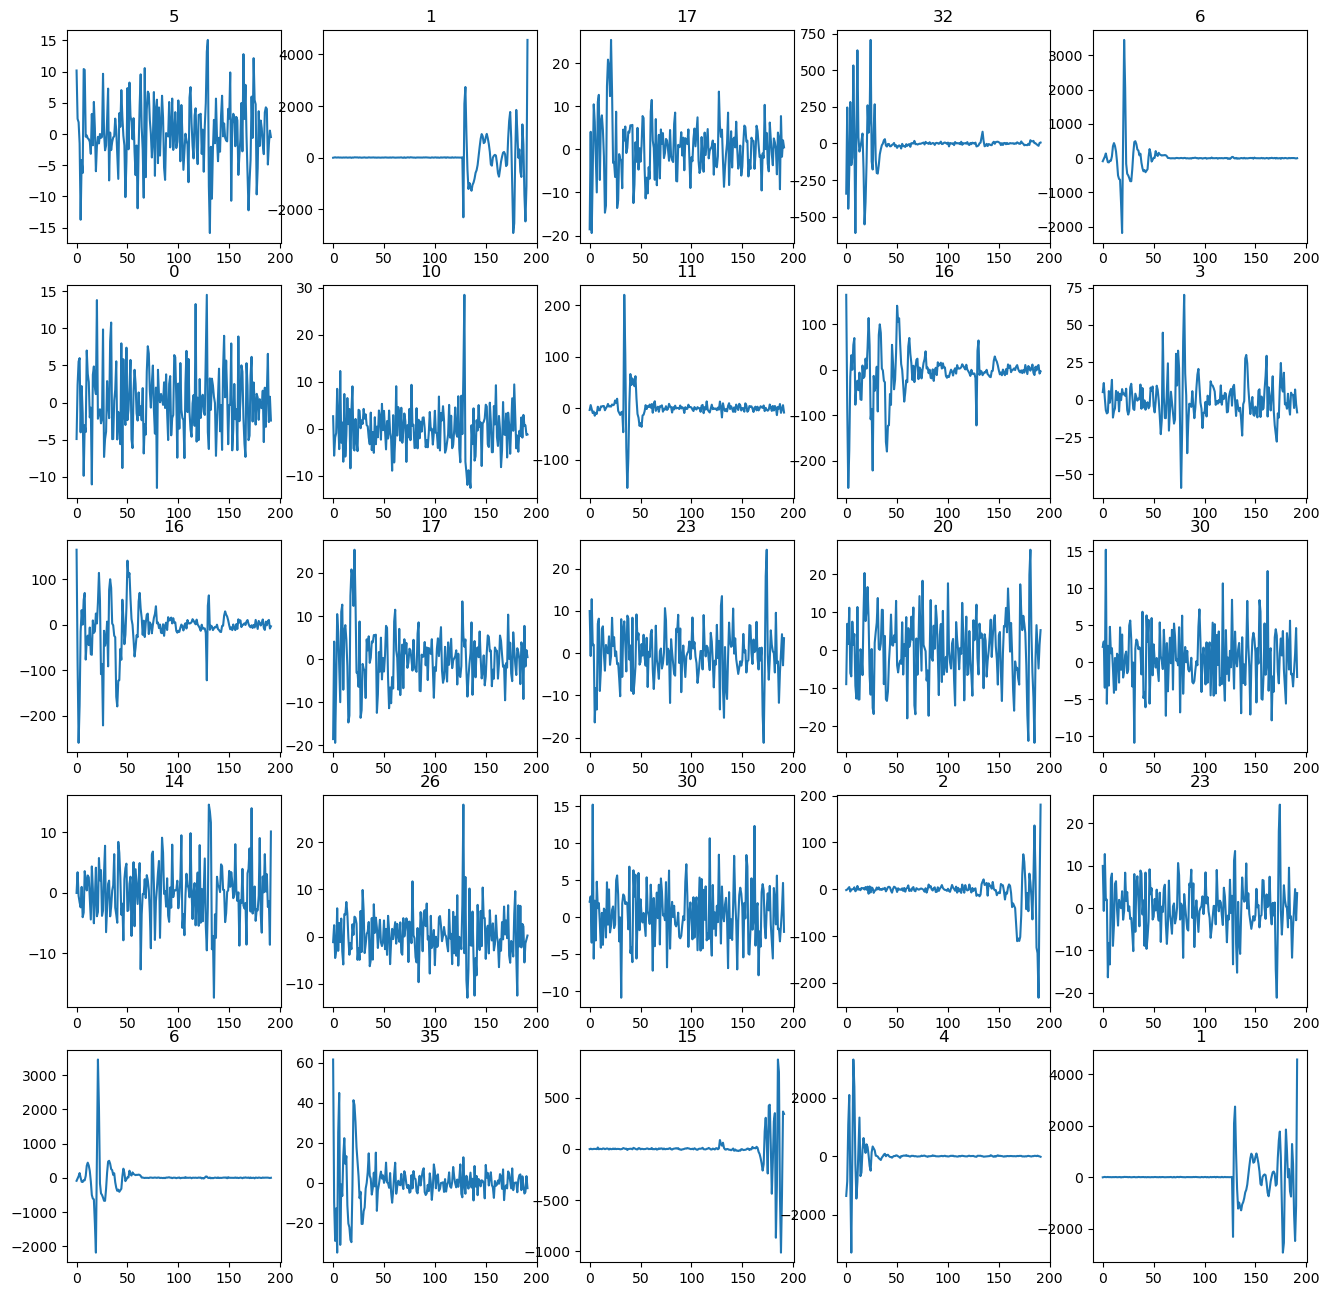

In [72]:
fig, axs = plt.subplots(5,5,figsize=(16,16))

for i in range(5):
    for j in range(5):
        ind = np.random.randint(len(true))
        axs[i,j].plot(true_grb[ind] - pred_grb[ind])
        axs[i,j].title.set_text('{}'.format(ind))

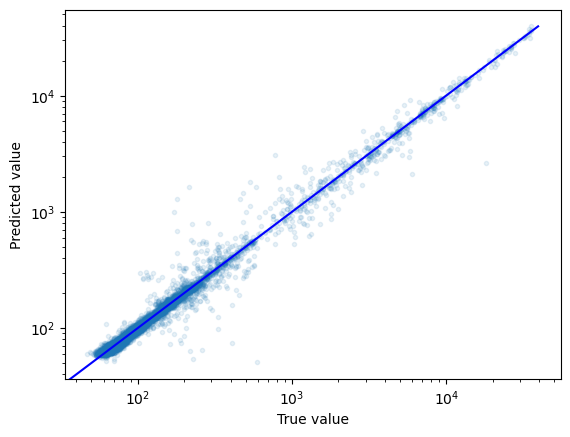

In [77]:
plt.scatter(true_grb,pred_grb,marker='.', alpha=0.1)
p1 = max(np.max(pred_grb), np.max(true_grb))
p2 = min(np.min(pred_grb), np.min(true_grb))
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.xscale('log')
plt.yscale('log')
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')
plt.plot([p1, p2], [p1, p2], 'b-')

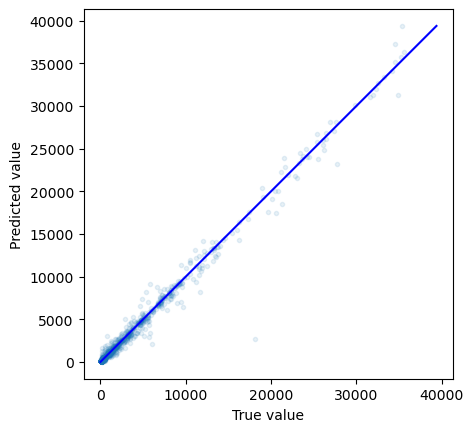

In [88]:
plt.scatter(true_grb,pred_grb,marker='.', alpha=0.1)
p1 = max(np.max(pred_grb), np.max(true_grb))
p2 = min(np.min(pred_grb), np.min(true_grb))
plt.xlabel('True value')
plt.ylabel('Predicted value')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.plot([p1, p2], [p1, p2], 'b-')

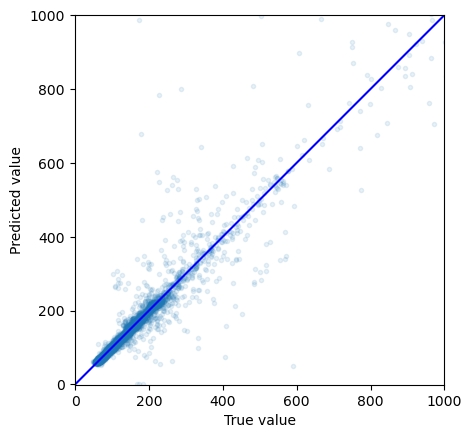

In [90]:
plt.scatter(true_grb,pred_grb,marker='.', alpha=0.1)
p1 = max(np.max(pred_grb), np.max(true_grb))
p2 = min(np.min(pred_grb), np.min(true_grb))
plt.xlabel('True value')
plt.ylabel('Predicted value')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlim(-1,1000)
plt.ylim(-1,1000)
plt.plot([p1, p2], [p1, p2], 'b-')

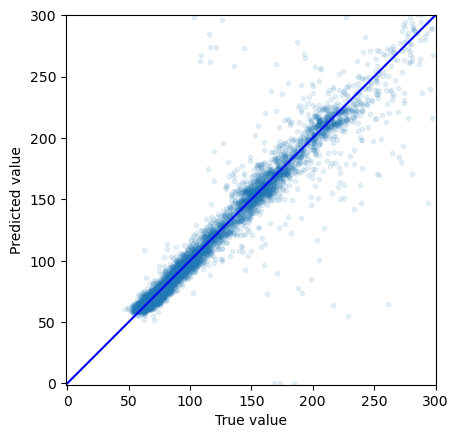

In [91]:
plt.scatter(true_grb,pred_grb,marker='.', alpha=0.1)
p1 = max(np.max(pred_grb), np.max(true_grb))
p2 = min(np.min(pred_grb), np.min(true_grb))
plt.xlabel('True value')
plt.ylabel('Predicted value')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlim(-1,300)
plt.ylim(-1,300)
plt.plot([p1, p2], [p1, p2], 'b-')

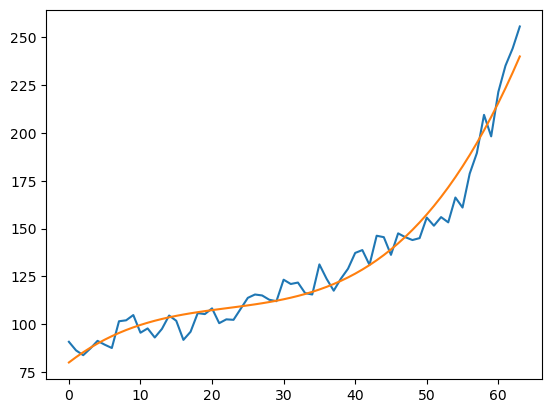

In [111]:
whii = 2
bkg_fit = np.polyfit(x,X[whii],3)
plt.plot(X[whii])
#plt.plot(np.polyval(bkg_fit,x))
plt.plot(x, bkg_fit[0]*x**3 + bkg_fit[1]*x**2 + bkg_fit[2]*x**1 + bkg_fit[3])

In [182]:
poly3,poly2,poly1,poly0, noise = [],[],[],[],[]
fittage = []
for i in range(len(X)):
    fit = np.polyfit(x,X[i],3)
    poly3.append(fit[0])
    poly2.append(fit[1])
    poly1.append(fit[2])
    poly0.append(fit[3])
    y = fit[0]*x**3 + fit[1]*x**2 + fit[2]*x**1 + fit[3]
    noise.append(X[i]-y)
    fittage.append(y)

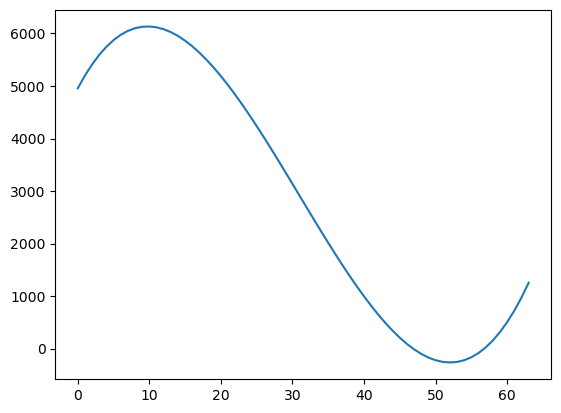

In [194]:
plt.plot(fit[0]*x**3 + fit[1]*x**2 + fit[2]*x**1 + fit[3])

In [190]:
y[0]

4956.230263672892

poly3:
Mean: -0.00013031650743879232
Standard Deviation: 0.20604085539093056
Median: 2.2368479753503807e-06
Minimum: -1.9273302219579784
Maximum: 1.9471568655648073

poly2:
Mean: 0.015489344565454638
Standard Deviation: 20.192516609946534
Median: 0.0033899960204203322
Minimum: -207.7431172676264
Maximum: 163.55309726988736

poly1:
Mean: -0.17289726723111898
Standard Deviation: 550.1812475414531
Median: -0.1601774424671435
Minimum: -4482.131004016171
Maximum: 5838.441044926975

poly0:
Mean: 2118.3330725972264
Standard Deviation: 6345.986995565329
Median: 126.74358593831545
Minimum: -17797.448540731726
Maximum: 52654.084860335606

noise:
Mean: -6.297402960322132e-13
Standard Deviation: 1176.6054878101704
Median: -0.14296547740622145
Minimum: -29992.14399756022
Maximum: 31096.3100040298



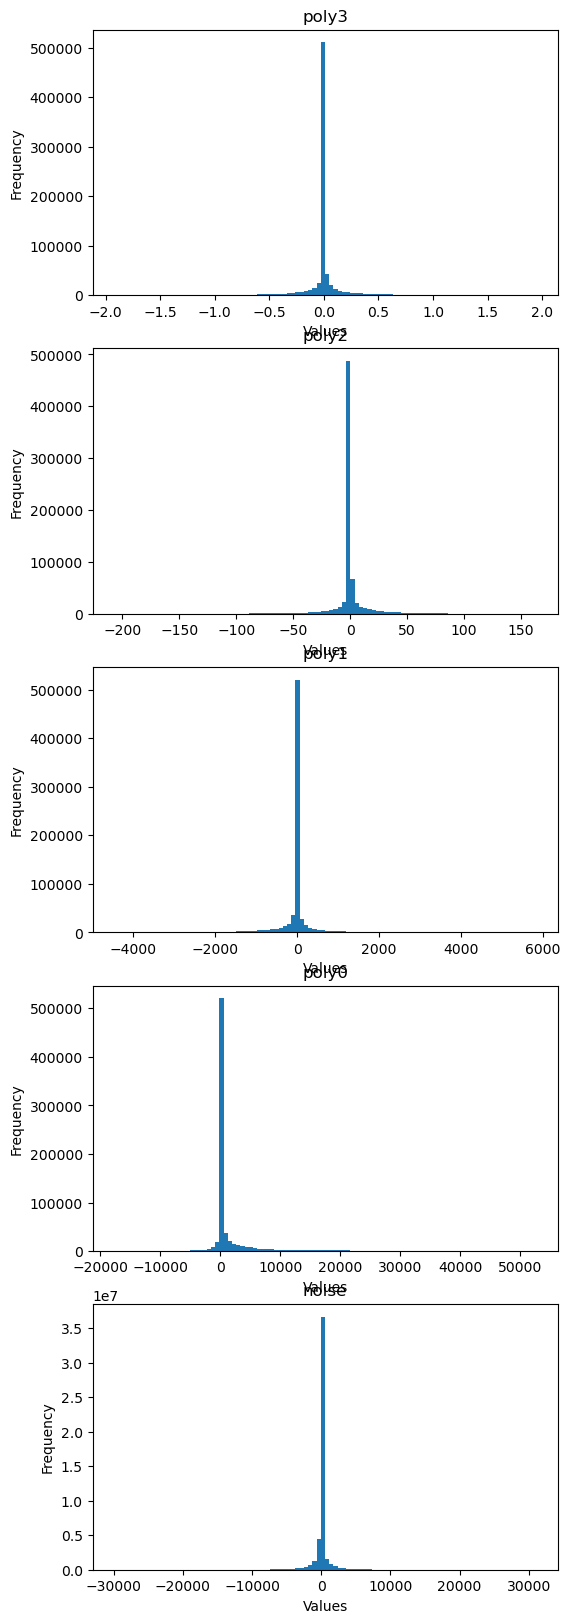

In [136]:
fig, axs = plt.subplots(5, 1, figsize=(6, 20))


data = [poly3, poly2, poly1, poly0, np.array(noise).flatten()]
titles = ['poly3', 'poly2', 'poly1', 'poly0', 'noise']
for i in range(len(data)):
    arr = data[i]
    print(f"{titles[i]}:")
    print("Mean:", np.mean(arr))
    print("Standard Deviation:", np.std(arr))
    print("Median:", np.median(arr))
    print("Minimum:", np.min(arr))
    print("Maximum:", np.max(arr))
    print()
for i in range(len(data)):
    ax = axs[i]
    ax.hist(data[i], bins=100)
    ax.set_title(titles[i])
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')

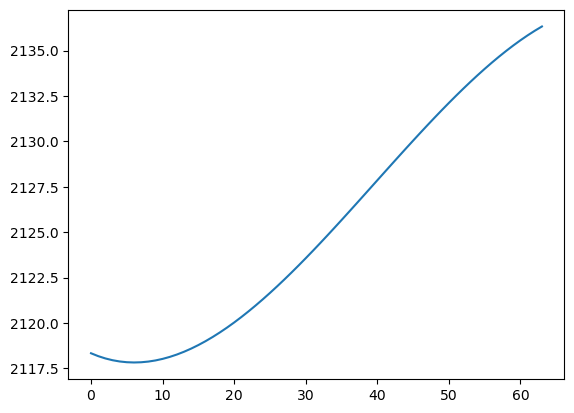

In [120]:
poly_x, poly_y = poly_gen(windowSize,-0.00013031650743879232, 0.015489344565454638, -0.17289726723111898,2118.3330725972264)
plt.plot(poly_x,poly_y)

In [ ]:
#autoencoder.save("autoencoder_conv1d")